In [4]:
import torch
from torch import nn
import torch.nn.functional as F
import fxcmpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from pandas.plotting import register_matplotlib_converters
import skimage as sk
from skimage.transform import resize
register_matplotlib_converters()

def connect():
    return fxcmpy.fxcmpy(access_token=access_token, server=server)

def getDF():

    df = con.get_candles(symbol2, period=timeframe, number=n_prices)
    df['close'] = np.round((df.bidclose + df.askclose) / 2, 5)
    df['open'] = np.round((df.bidopen + df.askopen) / 2, 5)

    df['ma5'] = np.round(df.close.rolling(5).mean(), 5)
    df['ma7'] = np.round(df.close.rolling(7).mean(), 5)
    df['ma10'] = np.round(df.close.rolling(10).mean(), 5)
    df['ma7_shift3'] = df.ma7.shift(-3)
    df['ma10_shift3'] = df.ma10.shift(-3)
    df['close_shift3'] = df.close.shift(-3)
    df.dropna(inplace=True)

    df['close_target_percent'] = np.round(((df['close_shift3']-df['close'])*10000)/df.close, 2)
    df['7_10_target_percent'] = np.round(((df['ma7_shift3']-df['ma10_shift3'])*10000)/df['ma10_shift3'], 2)
    df['5_7_target_percent'] = np.round(((df.ma5-df.ma7)*10000)/df.ma7, 2)

    print(df.shape)

    df['Target'] = np.ones(len(df))
    df['Target'].loc[(df['close_target_percent'] > 1) & (df['7_10_target_percent'] > 1) & (df['5_7_target_percent'] > 1)] = 2
    df['Target'].loc[(df['close_target_percent'] < -1) & (df['7_10_target_percent'] < -1) & (df['5_7_target_percent'] < -1)] = 0
    print(df.Target.value_counts())

    df.drop(['bidopen', 'bidclose', 'bidhigh', 'bidlow', 'askopen', 'askclose', 'askhigh', 'asklow', 'tickqty'], axis=1, inplace=True)
    df.dropna(inplace=True)
    print(df.info())

    return df

def getXY(df, windows):

    X = []
    Y = []
    for i in range(len(df)-(windows+1)):
        fig = plt.figure(frameon=False)
        fig.set_size_inches(3,2)
        ax = plt.Axes(fig, [0., 0., 1., 1.])
        ax.set_axis_off()
        fig.add_axes(ax)

        _df = df.iloc[i:windows]
        plt.plot(_df.ma5, color='red')
        plt.plot(_df.ma7, color='blue')
        plt.plot(_df.ma10, color='green')
        #plt.plot(_df.ma20, color='blue')
        #plt.plot(_df.open, color='black')
        #plt.plot(_df.close, color='purple')

        plt.savefig('tmp2.png')

        plt.close()

        img = plt.imread('tmp2.png')
        new_img = resize(img, (100,150))
        #print(new_img.shape)
        if i % 1000 == 0:
            print(i)
            plt.imshow(new_img)
            plt.show()
            print(i, ' - ', windows)
            print('target: ', df.Target.iloc[windows-1])
        X.append(new_img)
        Y.append(df.Target.iloc[windows-1])

        windows += 1

    return X, Y

def saveXY(x_train, y_train, x_test, y_test):
    with open('data/x_train_' + symbol + '_' + timeframe + '_' + str(n_prices) + '.pickle', 'wb') as file:
        pickle.dump(x_train, file)
    with open('data/y_train_' + symbol + '_' + timeframe + '_' + str(n_prices) + '.pickle', 'wb') as file:
        pickle.dump(y_train, file)
    with open('data/x_test_' + symbol + '_' + timeframe + '_' + str(n_prices) + '.pickle', 'wb') as file:
        pickle.dump(x_test, file)
    with open('data/y_test' + symbol + '_' + timeframe + '_' + str(n_prices) + '.pickle', 'wb') as file:
        pickle.dump(y_test, file)

In [5]:
# nope : euraud, eurchf, eurnzd, gbpaud, gbpnzd, cadjpy
access_token = '757cf3bec951c194aaa61c9db954c6533d251f2f'
server = 'real'
symbol = 'CADJPY'
symbol2 = 'CAD/JPY'
timeframe = 'm30'
n_prices = 2000
windows = 6
K = 3

In [6]:
con = connect()

|WARNING|2019-07-30 22:56:20,750|Default account set to 96112465, to change use set_default_account().


In [7]:
df = getDF()

(1988, 20)
1.0    1506
2.0     272
0.0     210
Name: Target, dtype: int64
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1988 entries, 2019-06-03 18:00:00 to 2019-07-30 13:30:00
Data columns (total 12 columns):
close                   1988 non-null float64
open                    1988 non-null float64
ma5                     1988 non-null float64
ma7                     1988 non-null float64
ma10                    1988 non-null float64
ma7_shift3              1988 non-null float64
ma10_shift3             1988 non-null float64
close_shift3            1988 non-null float64
close_target_percent    1988 non-null float64
7_10_target_percent     1988 non-null float64
5_7_target_percent      1988 non-null float64
Target                  1988 non-null float64
dtypes: float64(12)
memory usage: 201.9 KB
None


/anaconda2/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [9]:
df.head()

,close,open,ma5,ma7,ma10,ma7_shift3,ma10_shift3,close_shift3,close_target_percent,7_10_target_percent,5_7_target_percent,Target
date,,,,,,,,,,,,
2019-06-03 18:00:00,80.4650,80.3690,80.3799,80.40007,80.38970,80.37107,80.37965,80.3175,-18.33,-1.07,-2.51,0.0
2019-06-03 18:30:00,80.4000,80.4650,80.4003,80.39379,80.40610,80.36743,80.37130,80.3605,-4.91,-0.48,0.81,1.0
2019-06-03 19:00:00,80.2785,80.4000,80.3788,80.36829,80.39075,80.37336,80.36790,80.4230,18.00,0.68,1.31,1.0
2019-06-03 19:30:00,80.3175,80.2785,80.3660,80.37107,80.37965,80.37393,80.37540,80.3730,6.91,-0.18,-0.63,1.0
2019-06-03 20:00:00,80.3605,80.3175,80.3643,80.36743,80.37130,80.36286,80.37555,80.3875,3.36,-1.58,-0.39,1.0


1.0    886
2.0    188
0.0    118
Name: Target, dtype: int64
1.0    620
0.0     92
2.0     84
Name: Target, dtype: int64
0


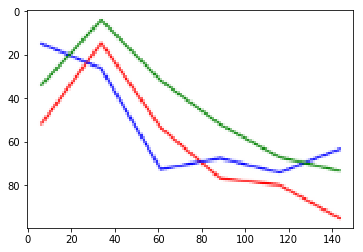

0  -  6
target:  0.0
1000


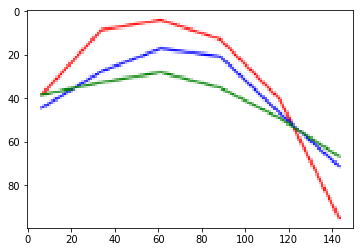

1000  -  1006
target:  1.0
0


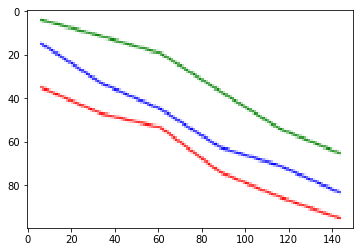

0  -  6
target:  1.0


In [10]:
split = int(len(df) * 0.60)
print(df.iloc[:split].Target.value_counts())
print(df.iloc[split:].Target.value_counts())

x_train, y_train = getXY(df.iloc[:split], windows)
x_train = np.array(x_train, np.float32) / 255
y_train = np.array(y_train, np.long)
x_test, y_test = getXY(df.iloc[split:], windows)
x_test = np.array(x_test, np.float32) / 255
y_test = np.array(y_test, np.long)

In [11]:
saveXY(x_train, y_train, x_test, y_test)

FileNotFoundError: [Errno 2] No such file or directory: 'data/x_train_CADJPY_m30_2000.pickle'

In [7]:
##########################
### MODEL
##########################


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 16
        if grayscale:
            in_dim = 1
        else:
            in_dim = 4
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 16, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 32, layers[0])
        self.layer2 = self._make_layer(block, 64, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 128, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 256, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.fc = nn.Linear((256*2*3) * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = F.dropout(x)

        x = self.layer1(x)
        x = F.dropout(x)
        x = self.layer2(x)
        x = F.dropout(x)
        x = self.layer3(x)
        x = F.dropout(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = F.dropout(x)
        #print(x.size())
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        x = F.dropout(x)

        return logits


def resnet18(num_classes):
    """Constructs a ResNet-18 model."""
    model = ResNet(block=BasicBlock,
                   layers=[2, 2, 2, 2],
                   num_classes=num_classes,
                   grayscale=False)
    return model

In [8]:

def init_weights(m):
#     if isinstance(m, nn.Linear):
#       size = m.weight.size()
#       fan_out = size[0] # number of rows
#       fan_in = size[1] # number of columns
#       variance = np.sqrt(2.0/(fan_in))
#       m.weight.data.normal_(0.0, variance)
#       if m.bias is not None:
#         m.bias.data.fill_(0)
#     elif isinstance(m, nn.Conv2d):
#       size = m.weight.size()
#       fan_out = size[0] # number of rows
#       fan_in = size[1] # number of columns
#       variance = np.sqrt(2.0/(fan_in))
#       m.weight.data.normal_(0.0, variance)
#       if m.bias is not None:
#         m.bias.data.fill_(0)

    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.01)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

#     if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
#         import scipy.stats as stats
#         X = stats.truncnorm(-2, 2, scale=0.01)
#         values = torch.as_tensor(X.rvs(m.weight.numel()), dtype=m.weight.dtype)
#         values = values.view(m.weight.size())
#         with torch.no_grad():
#             m.weight.copy_(values)
#     elif isinstance(m, nn.BatchNorm2d):
#         nn.init.constant_(m.weight, 1)
#         nn.init.constant_(m.bias, 0)

In [ ]:
class RNN(nn.Module):
    def __init__(self, hidden, K, input_size):
        super(RNN, self).__init__()
        
        self.linearH = nn.Linear(input_size + hidden, hidden)
        self.linearO = nn.Linear(input_size + hidden, K)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x, h):
        x = torch.cat((x, h), 1)
        h = torch.tanh(self.linearH(x))
        out = self.softmax(self.linearO(x))
        
        return out, h

In [12]:
x_train.shape

(1185, 100, 150, 4)

In [15]:
x_train[0].reshape(1, -1)

array([[0.00392157, 0.00392157, 0.00392157, ..., 0.00392157, 0.00392157,
        0.00392157]], dtype=float32)

In [9]:
epochs = 200
batch_size = 8
train_costs = []
test_costs = []
train_accs = []
test_accs = []
hidden = 128
K = 3
input_size = x_train.shape[1]

#model = resnet18(K)
model = RNN(hidden, K, input_size)
model.apply(init_weights)
model.cuda()

best_loss = 999.99
best_acc = 0
training_data = np.transpose(x_train, (0, 3, 1, 2))
testing_data = np.transpose(x_test, (0, 3, 1, 2))

C = x_train.shape[3]

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

lambda1 = lambda epoch: epochs // 30
#lambda2 = lambda epoch: 0.95 ** epochs
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1])
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.01)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)
#model.load_state_dict(torch.load('model/torch'))
#model.eval()
n_batch = int(len(x_train) / batch_size)

x_test_input = torch.tensor(testing_data, dtype=torch.float32, device='cuda')
y_test_input = torch.tensor(y_test, dtype=torch.long, device='cuda')
    
for i in range(epochs):

    running_loss = 0.0
    running_acc = 0.0
    model.train()

    for j in range(n_batch):
        x_batch = training_data[j*batch_size:j*batch_size+batch_size]
        y_batch = y_train[j*batch_size:j*batch_size+batch_size]

        x_input = torch.tensor(x_batch, dtype=torch.float32, device='cuda')
        y_input = torch.tensor(y_batch, dtype=torch.long, device='cuda')

        optimizer.zero_grad()
        logits = model(x_input)
        pred = F.softmax(logits, dim=1)
        loss = loss_fn(logits, y_input)

        acc = np.mean(pred.cpu().detach().numpy().argmax(1) == y_batch)
        
        running_loss += loss.item()/n_batch
        running_acc += acc / n_batch

        reg_loss = None
        for param in model.parameters():
            if reg_loss is None:
                reg_loss = 0.5 * torch.sum(param**2)
            else:
                reg_loss = reg_loss + 0.5 * param.norm(2)**2

        loss += 0.0001 * reg_loss

        loss.backward()
        optimizer.step()

    model.eval()


    test_logits = model(x_test_input)
    test_pred = F.softmax(test_logits, dim=1)
    test_loss = loss_fn(test_logits, y_test_input)
    test_acc = np.mean(test_pred.cpu().detach().numpy().argmax(1) == y_test)
    scheduler.step(test_loss)
    
    train_costs.append(running_loss)
    test_costs.append(test_loss.item())
    train_accs.append(running_acc)
    test_accs.append(test_acc)
    
#     if test_loss.item() < best_loss:
#         best_loss = test_loss.item()
#         torch.save(model.state_dict(), 'model/torch')
#     if test_acc > best_acc:
#         best_acc = test_acc
#         torch.save(model.state_dict(), 'model/torch2')
        
    if i % 10 == 0:
        print(i, ' Train loss: ', running_loss, ' Train acc: ', running_acc, ' Test loss: ', test_loss.item(), ' Test acc: ', test_acc)
    
    unique, counts = np.unique(test_pred.cpu().detach().numpy().argmax(1), return_counts=True)
    #print('\nUniqlo')
    if i % 10 == 0:
        print(np.asarray((unique, counts)).T)
        print('Best acc: ', best_acc)

    x_0 = []
    x_1 = []
    x_2 = []

    y_0 = np.where(y_test == 0.0)
    y_2 = np.where(y_test == 2.0)
    y_1= np.where(y_test == 1.0)

    for i in y_0[0]:
        x_0.append(x_test[i])
    for i in y_1[0]:
        x_1.append(x_test[i])
    for i in y_2[0]:
        x_2.append(x_test[i])

    x_0 = np.array(x_0)
    x_1 = np.array(x_1)
    x_2 = np.array(x_2)

    x_0 = np.transpose(x_0, (0, 3, 1, 2))
    x_1 = np.transpose(x_1, (0, 3, 1, 2))
    x_2 = np.transpose(x_2, (0, 3, 1, 2))

    pred_0 = model(torch.tensor(x_0, dtype=torch.float32, device='cuda')).cpu().detach().numpy().argmax(1)
    pred_1 = model(torch.tensor(x_1, dtype=torch.float32, device='cuda')).cpu().detach().numpy().argmax(1)
    pred_2 = model(torch.tensor(x_2, dtype=torch.float32, device='cuda')).cpu().detach().numpy().argmax(1)

    #print('\nPer class')
    acc_0 = np.mean(y_test[y_0[0]] == pred_0) * 100
    acc_1 = np.mean(y_test[y_1[0]] == pred_1) * 100
    acc_2 = np.mean(y_test[y_2[0]] == pred_2) * 100
    mean_acc = np.round((acc_0+acc_1+acc_2) / 3, 2)
    #print(mean_acc)

    # if i % 10 == 0:
    #   print(np.round(acc_0, 2))
    #   print(np.round(acc_1, 2))
    #   print(np.round(acc_2, 2))
    #   print(mean_acc)
    #   print(np.max(pred_0))
    #   print(np.min(pred_2))

    if mean_acc > best_acc and np.max(pred_0) ==1 and np.min(pred_2) == 1:
        best_acc = mean_acc
        torch.save(model.state_dict(), 'torch_' + symbol + '_m30')
        print('saved!')

0  Train loss:  0.8422212921888439  Train acc:  0.7246621621621628  Test loss:  0.5985057353973389  Test acc:  0.7921419518377694
[[  1 785]
 [  2   4]]
Best acc:  0
saved!
saved!
10  Train loss:  0.5487562254876702  Train acc:  0.7280405405405409  Test loss:  0.5560491681098938  Test acc:  0.788339670468948
[[  0   5]
 [  1 784]]
Best acc:  34.12
saved!
saved!
saved!
20  Train loss:  0.4660993117738415  Train acc:  0.7736486486486494  Test loss:  0.6142698526382446  Test acc:  0.7908745247148289
[[  0   2]
 [  1 786]
 [  2   1]]
Best acc:  35.7
saved!
saved!
saved!
30  Train loss:  0.3452886989390528  Train acc:  0.8538851351351361  Test loss:  0.6035572290420532  Test acc:  0.7553865652724968
[[  0  33]
 [  1 726]
 [  2  30]]
Best acc:  40.81
40  Train loss:  0.22199675319968049  Train acc:  0.9028716216216227  Test loss:  1.0722942352294922  Test acc:  0.7782002534854245
[[  0   2]
 [  1 772]
 [  2  15]]
Best acc:  40.81
50  Train loss:  0.13367148880167193  Train acc:  0.9434121621

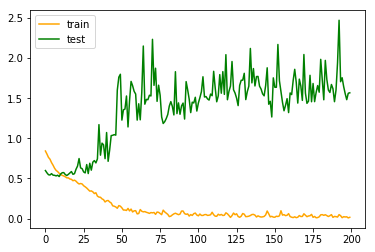

In [10]:
plt.plot(train_costs, label='train', color='orange')
plt.plot(test_costs, label='test', color='green')
plt.legend()
plt.show()

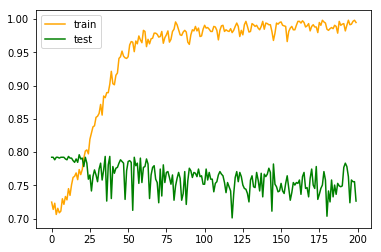

In [11]:
plt.plot(train_accs, label='train', color='orange')
plt.plot(test_accs, label='test', color='green')
plt.legend()
plt.show()

In [14]:
def calScore(model, x_test, y_test, test_pred):

    unique, counts = np.unique(test_pred.cpu().detach().numpy().argmax(1), return_counts=True)

    print(np.asarray((unique, counts)).T)
    print('------')
    x_0 = []
    x_1 = []
    x_2 = []

    y_0 = np.where(y_test == 0.0)
    y_2 = np.where(y_test == 2.0)
    y_1= np.where(y_test == 1.0)

    for i in y_0[0]:
        x_0.append(x_test[i])
    for i in y_1[0]:
        x_1.append(x_test[i])
    for i in y_2[0]:
        x_2.append(x_test[i])

    x_0 = np.array(x_0)
    x_1 = np.array(x_1)
    x_2 = np.array(x_2)

    x_0 = np.transpose(x_0, (0, 3, 1, 2))
    x_1 = np.transpose(x_1, (0, 3, 1, 2))
    x_2 = np.transpose(x_2, (0, 3, 1, 2))

    pred_0 = model(torch.tensor(x_0, dtype=torch.float32, device='cuda')).cpu().detach().numpy().argmax(1)
    pred_1 = model(torch.tensor(x_1, dtype=torch.float32, device='cuda')).cpu().detach().numpy().argmax(1)
    pred_2 = model(torch.tensor(x_2, dtype=torch.float32, device='cuda')).cpu().detach().numpy().argmax(1)

    #acc1
    trade_acc0 = len(pred_0[pred_0==0]) + len(pred_0[pred_0==2])
    print("Trade acc0: ", trade_acc0)
    acc0_win = len(pred_0[pred_0==0])
    print('acc0 win: ', acc0_win)
    acc0_loss = len(pred_0[pred_0==2])
    print('acc0 loss: ', acc0_loss)
    print('------')

    #acc2
    trade_acc2 = len(pred_2[pred_2==0]) + len(pred_2[pred_2==2])
    print("Trade acc2: ", trade_acc2)
    acc2_win = len(pred_2[pred_2==2])
    acc2_loss = len(pred_2[pred_2==0])
    print('acc2 win: ', acc2_win)
    print('acc2 loss: ', acc2_loss)
    print('------')

    #acc1
    trade_acc1 = len(pred_1[pred_1==0]) + len(pred_1[pred_1==2])
    print("Trade acc1: ", trade_acc1)
    acc1_loss = trade_acc1
    print('acc1 loss: ', acc1_loss)
    print('------')

    total_trade = trade_acc0 + trade_acc1 + trade_acc2
    print("total trade: ", total_trade)

    win_rate = 0.0
    loss_rate = 0.0
    if total_trade > 0:
        win_rate = (acc0_win + acc2_win) / total_trade * 100
        loss_rate = (acc0_loss + acc1_loss + acc2_loss) / total_trade * 100

    rr = 0.0
    if loss_rate > 0:
        rr = win_rate / loss_rate
    print('rr: ', rr)
    print('win rate: ', np.round(win_rate, 2))
    print('loss rate:', np.round(loss_rate, 2))
    print(pred_0.max())
    print(pred_2.min())

In [15]:
model.load_state_dict(torch.load('model/torch2'))
model.eval()
test_logits = model(x_test_input)
test_pred = F.softmax(test_logits, dim=1)
calScore(model, x_test, y_test, test_pred)

[[  0 128]
 [  1 661]]
------
Trade acc0:  22
acc0 win:  22
acc0 loss:  0
------
Trade acc2:  4
acc2 win:  0
acc2 loss:  4
------
Trade acc1:  82
acc1 loss:  82
------
total trade:  108
rr:  0.2558139534883721
win rate:  20.37
loss rate: 79.63
1
0


In [18]:
unique, counts = np.unique(np.argmax(pred, axis=1), return_counts=True)
print(np.asarray((unique, counts)).T)

x_0 = []
x_1 = []
x_2 = []
x_3 = []
x_4 = []

y_0 = np.where(y_test == 0.0)
y_1 = np.where(y_test == 1.0)
y_2 = np.where(y_test == 2.0)
y_3 = np.where(y_test == 3.0)
y_4 = np.where(y_test == 4.0)

for i in y_0[0]:
  x_0.append(x_test[i])
for i in y_1[0]:
  x_1.append(x_test[i])
for i in y_2[0]:
  x_2.append(x_test[i])
for i in y_3[0]:
  x_3.append(x_test[i])
for i in y_4[0]:
  x_4.append(x_test[i])

x_0 = np.array(x_0)
x_1 = np.array(x_1)
x_2 = np.array(x_2)
x_3 = np.array(x_3)
x_4 = np.array(x_4)

pred_0 = np.argmax(model.predict(x_0), axis=1)
pred_1 = np.argmax(model.predict(x_1), axis=1)
pred_2 = np.argmax(model.predict(x_2), axis=1)
pred_3 = np.argmax(model.predict(x_3), axis=1)
pred_4 = np.argmax(model.predict(x_4), axis=1)

acc_0 = np.mean(y_test[y_0[0]] == pred_0) * 100
acc_1 = np.mean(y_test[y_1[0]] == pred_1) * 100
acc_2 = np.mean(y_test[y_2[0]] == pred_2) * 100
acc_3 = np.mean(y_test[y_3[0]] == pred_3) * 100
acc_4 = np.mean(y_test[y_4[0]] == pred_4) * 100

print(np.round(acc_0, 2))
print(np.round(acc_1, 2))
print(np.round(acc_2, 2))
print(np.round(acc_3, 2))
print(np.round(acc_4, 2))
print('Mean: ', np.round((acc_0+acc_1+acc_2+acc_3+acc_4) / 5, 2))

win = acc_1 + acc_2 + acc_3 + acc_4
lose = 100 - acc_0
rr = win/lose
print('RR: ', np.round(rr, 2))

RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.